<a href="https://colab.research.google.com/github/sanghoho/Fastai-Manager/blob/master/Fastai_Manager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fastai 매니저 

> 기존에 개인적으로 `fastai`를 사용하며 반복되던 프로세스를 단순화하고, 실험을 편리하게 한다. 또한 부수적으로 개발하여 사용했던 내용을 통합한다.

## 2020년 08월 18일 안상호

1. 클래스 소개 
2. 이미지 데이터 적용
3. 테이블 데이터 적용
4. 텍스트 데이터 적용 
5. 임베딩 해석기, LIME($+ \alpha$)

`FastManager`는 Computer Vision을 담당하는 `FastVision`, Natural Language Processing을 담당하는 `FastText`, 그리고 Tabular Data를 담당하는 `FastTabular` 등으로 이루어져있습니다.

또한 학습 결과로 얻어지는 Feature들에 대한 분석 및 해석에도 초점을 맞추어 **임베딩 해석**, **feature map**, **LIME**을 통한 분류 모델 분석 등을 포함합니다.


# Requirement

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from pathlib import Path

colab_project = "20F-MCRI"
  
root_dir = Path("/content/gdrive/My Drive/Colab Notebooks/")
base_dir = root_dir / colab_project
data_path = base_dir / "data"

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
!pip install "torch==1.4" "torchvision==0.5.0" # if you using colab

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 33.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [5]:
from fastai.vision import *
from fastai.tabular import *

# 1. 클래스 소개

## 1.1. FastVision

1. 어떤 아키텍쳐를 사용할 것인가? (**ConvNet** or **Unet**)
2. 어떤 작업을 수행할 것인가? (**Classification** or **Regression**)

- `DataBunch`
  + train-valid
- Create and Train `Learner`
- Train
- Interpretaion


In [6]:
class FastVision:
  def __init__(self, arch, parameters, task=None, arch_type="convnet"):
    self.arch = arch
    if arch_type.lower() == "convnet":
      self.__init_cnn(task, parameters)
    elif arch_type.lower() == "unet":
      self.__init_unet(parameters)
    else:
      raise NameError(f'This architecture "{arch_type}"" does not support! "convnet" or "unet"')

  def __init_cnn(self, task, parameters):
    self.task = task
    if task.lower() == "classification":
      self.__init_cnn_cls(parameters)
    elif task.lower() == "regression":
      self.__init_cnn_reg(parameters)
    elif task is None:
      raise ValueError(f'task Value is None! "classification" or "regression"')
    else:
      raise ValueError(f'This task "{task}"" does not support! "classification" or "regression"')

  def __init_cnn_cls(self, parameters):
    """
    Initialize CNN parameter for Classification
    Create DataBunch and Learner for Classification
    """
    path = parameters["path"]
    bs = parameters["bs"] 
    size = parameters["size"] 
    valid_pct = parameters["valid_pct"]

    metrics = parameters["metrics"]
    pretrained = parameters["pretrained"] 
    load_dir = parameters["load_dir"]


    bunch = self.create_cls_cnn_databunch(path, bs, size, valid_pct)
    bunch.show_batch(rows=3, figsize=(12,9))

    self.learn = self.create_cls_cnn_learner(bunch, metrics, pretrained, load_dir)

  def create_cls_cnn_databunch(self, path, bs=16, size=128, valid_pct=0.2):
    tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
    src = (ImageList.from_folder(path)
       .split_by_rand_pct(valid_pct)
       .label_from_folder())
    
    bunch = (src.transform(tfms, size=size)
        .databunch(bs=bs, no_check=True).normalize(imagenet_stats))
    return bunch 

  def create_cls_cnn_learner(self, data, metrics=[accuracy], pretrained=True, load_dir=None):
    learn = cnn_learner(data, self.arch, metrics=metrics, pretrained=pretrained)
    if load_dir is not None:
      learn.load(load_dir) 
    return learn

  def __init_cnn_reg(self, parameters):
    """
    Initialize CNN parameter for Regression
    Create DataBunch and Learner for Regression
    """

    df = parameters["df"]
    colnames = parameters["colnames"] 
    parent_path = parameters["parent_path"]
    folder = parameters["folder"]
    bs = parameters["bs"] 
    size=parameters["size"] 
    valid_pct=parameters["valid_pct"]

    metrics = parameters["metrics"]
    pretrained = parameters["pretrained"] 
    load_dir = parameters["load_dir"]

    final_size = parameters["final_size"]
    y_range = parameters["y_range"]

    bunch = self.create_reg_cnn_databunch(df, colnames, parent_path, folder,
                                          bs, size, valid_pct)
    bunch.show_batch(rows=3, figsize=(12,9))

    self.learn = self.create_reg_cnn_learner(bunch, final_size, y_range, metrics, pretrained, load_dir)

  def __init_unet(self, parametes):
    pass


  def create_reg_cnn_databunch(self, df, colnames, parent_path, folder, bs=16, size=128, valid_pct=0.2):

    label_df = pd.read_csv(parent_path / df)[pd.Index(colnames)]
    print(label_df.head())

    tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
    
    src = (ImageList.from_df(label_df,  parent_path, folder=folder)
       .split_by_rand_pct(0.2)
       .label_from_df(label_cls=FloatList))
 
    bunch = (src.transform(tfms, size=size)
             .databunch(bs=bs, no_check=True).normalize(imagenet_stats))
    return bunch 


  

  def create_reg_cnn_learner(self, data, final_size, y_range=None, metrics=[root_mean_squared_error, r2_score], pretrained=True, load_dir=None):

    model = ImageRegression(self.arch, final_size, pretrained, y_range)

    learn = Learner(data, model, metrics=metrics,
                    callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)
    learn.loss_func = L1LossFlat()

    learn = cnn_learner(data, self.arch, metrics=metrics, pretrained=pretrained)
    if load_dir is not None:
      learn.load(load_dir) 
    return learn

  def find_alpha(self, suggestion=True):
    self.learn.lr_find()
    self.learn.recorder.plot(suggestion=suggestion)

  def fit_model_cyc(self, epoch, alpha=5e-02, wd=0.2):
    """
    fit_one_cycle로 모델을 학습 
    learner를 학습하고, 모델의 확률 예측함수 반환 
    """
    self.learn.fit_one_cycle(epoch, alpha, wd=wd)
    self.predict_prob = lambda x: np.array([self.learn.predict(row)[2].detach().numpy().astype(float) for _, row in pd.DataFrame(x, columns=fastlime.feature_names).iterrows()])    



class ImageRegression(nn.Module):
  def __init__(self, arch, final_size, pretrained=True, y_range=None):
    super().__init__()
    layers = list(arch(pretrained=pretrained).children())[:-2]
    layers += [AdaptiveConcatPool2d(), Flatten()]
    layers += [nn.BatchNorm1d(final_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(final_size, int(final_size / 2), bias=True), nn.ReLU(inplace=True)]
    layers += [nn.BatchNorm1d(int(final_size / 2), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(int(final_size / 2), 16, bias=True), nn.ReLU(inplace=True)]
    layers += [nn.Linear(16,1)]
    self.imagereg = nn.Sequential(*layers)
    self.y_range = y_range
    
  def forward(self, x):
    x = self.imagereg(x).squeeze(-1)

    if self.y_range is not None:
      x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
    return x

class L1LossFlat(nn.SmoothL1Loss):
  def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
    return super().forward(input.view(-1), target.view(-1))

## 1.2. FastTabular



In [ ]:
def create_cls_tabular_databunch(data, path, procs, dep_var, cat_vars, cont_vars=None):
  bunch = (TabularList.from_df(data, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols=dep_var)
                .databunch())
  return bunch


def create_cls_tabular_learner(bunch, metrics=[accuracy], layers=[300, 100], load_dir=None):
  learn = tabular_learner(data, layers=layers, metrics=metrics)
  if load_dir is not None:
    learn.load(load_dir) 
  return learn


In [ ]:
class FastTabular:
  def __init__(self, task_type="regression"):
    if task_type.lower() == "regression":
      self.__init_reg()
    elif task_type.lower() == "classification":
      self.__init_cls()
    else:
      raise ArchError(f'This task {task_type} does not support! "regression" or "classification"')

  def __init_reg(self):
    self.task = task



  def __init_cls(self):
    pass

# 2. 이미지 데이터 적용


## 2.1. Image Classification

In [7]:
parameters = {
    "path" : root_dir  / 'EcoSatellite' / 'data' / "Land",
    "bs" : 32, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy],
    "pretrained" : True, 
    "load_dir": None
}

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


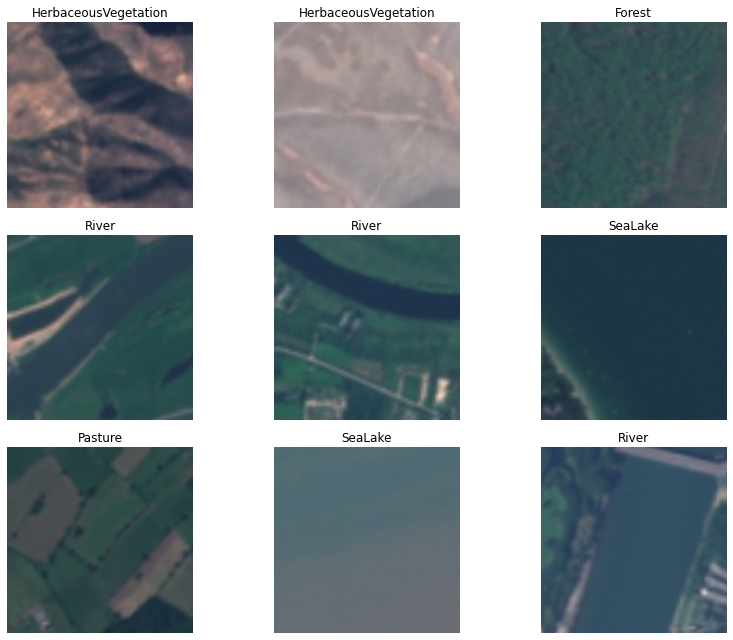

In [8]:
vis = FastVision(models.resnet34, parameters, task="classification")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.00E-02


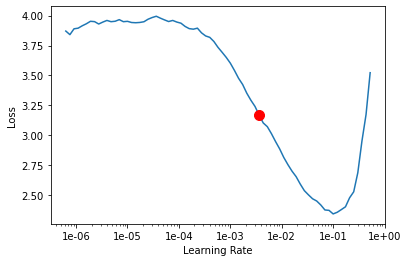

In [9]:
vis.find_alpha()

In [10]:
vis.fit_model_cyc(3, 5e-03)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

## 2.2. Image Regression

In [11]:
parameters = {
    "df": "meta_dhs.csv",
    "colnames": ["image_name", "wealth"],
    "parent_path": data_path / "repli",
    "folder": "poverty",
    "bs" : 32, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [root_mean_squared_error, r2_score],
    "pretrained" : True, 
    "load_dir": None,

    "final_size": 1024,
    "y_range": None

    
}

                               image_name    wealth
0           -12.101381_14.140703_2015.png -0.992088
1           -14.287585_17.621653_2015.png -0.436500
2           -14.211038_13.546263_2015.png -0.981815
3  -12.353335000000001_14.778694_2015.png  0.162535
4   -11.61019_14.460757999999998_2015.png -0.818061


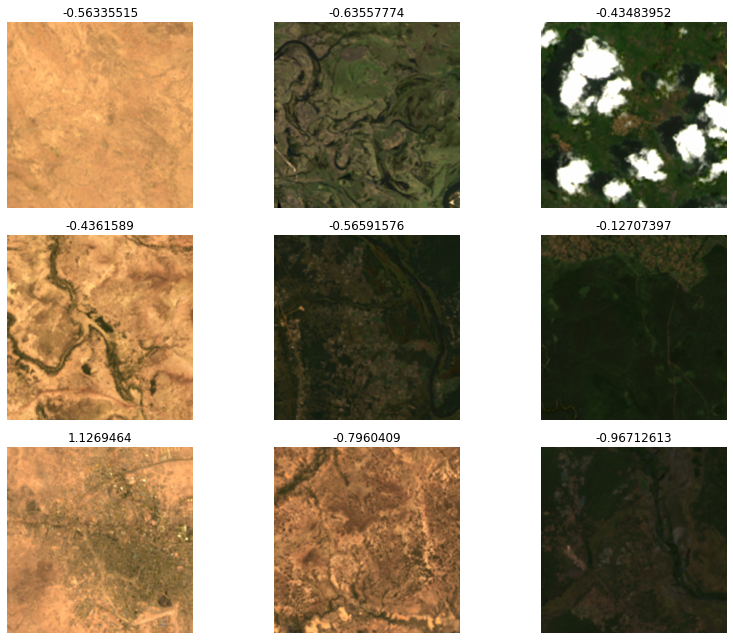

In [13]:
vis = FastVision(models.resnet34, parameters, task="regression")

In [ ]:
vis.find_alpha()

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


In [ ]:
vis.fit_model_cyc(5, )